In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u # I use astropy units in everything, very helpful for bookkeeping/debugging

from lim import lim # The base intensity mapping object

matplotlib.rcParams.update({'font.size': 18,'figure.figsize':[8,7]}) # Make figures better
#matplotlib.rcParams,update({}'figure.figsize'] = [8,7]
from scipy.ndimage import gaussian_filter

In [2]:
# Initialize LineModel with default model
m = lim()

In [3]:
m_noise = lim('Lichen',doSim=True)

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


In [4]:
noisy_2 = m_noise.noise_added_map
nonoise_2 = m_noise.maps

Loading .npz catalogues...


In [5]:
m_noise.update(tobs=40000*u.hr)

In [6]:
noisy_40 = m_noise.noise_added_map
nonoise_40 = m_noise.maps

Loading .npz catalogues...


In [7]:
m_noise.reset()

Here we take the 3rd index of the different redshifts:

In [8]:
ind = 3

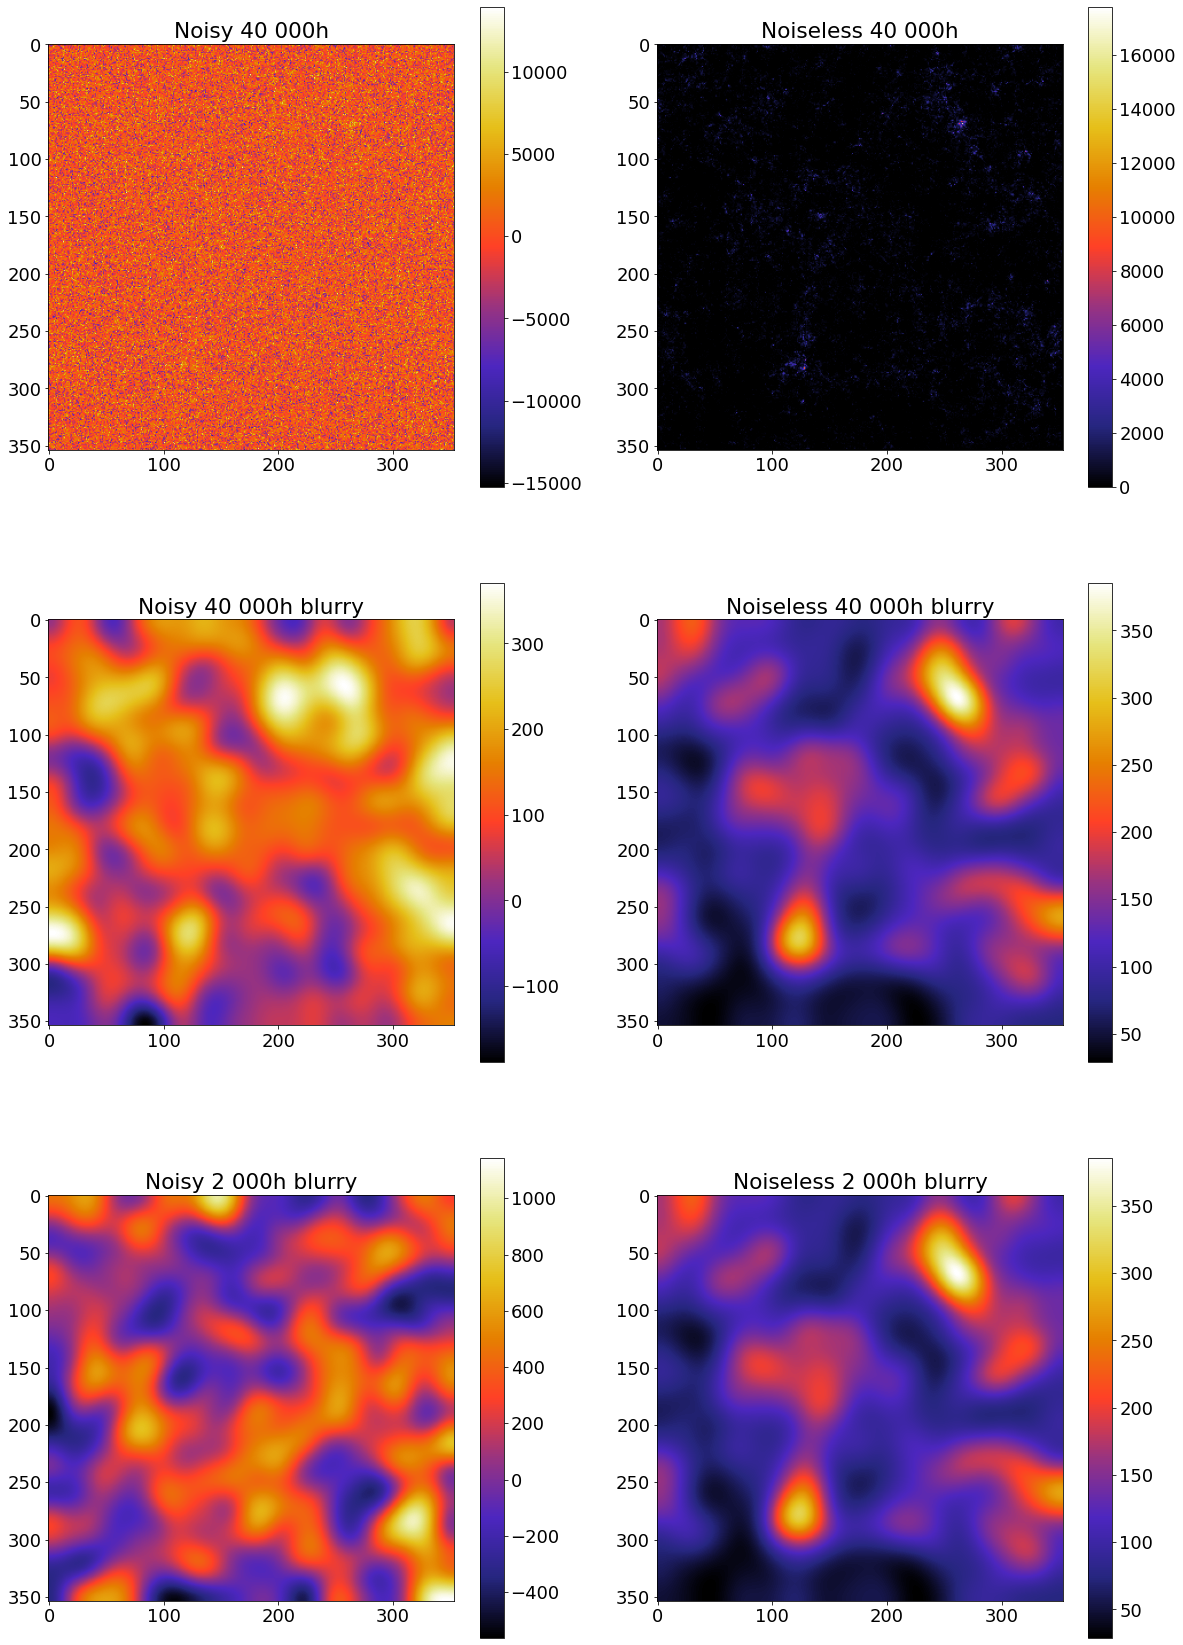

In [9]:
fig , axes = plt.subplots(nrows=3, ncols=2, figsize=(20,30))

plt.subplot(321)
plt.imshow(noisy_40[:,:, ind], cmap = 'CMRmap') 
plt.title('Noisy 40 000h') 
plt.colorbar()

plt.subplot(322)
plt.imshow(nonoise_40[:,:, ind], cmap = 'CMRmap') 
plt.title('Noiseless 40 000h')
plt.colorbar()

plt.subplot(323)
plt.imshow(gaussian_filter((noisy_40[..., ind]),15), cmap = 'CMRmap') 
plt.title('Noisy 40 000h blurry') 
plt.colorbar()

plt.subplot(324)
plt.imshow(gaussian_filter((nonoise_40[..., ind]),15), cmap = 'CMRmap') 
plt.title('Noiseless 40 000h blurry') 
plt.colorbar()

plt.subplot(325)
plt.imshow(gaussian_filter((noisy_2[..., ind]),15), cmap = 'CMRmap') 
plt.title('Noisy 2 000h blurry') 
plt.colorbar()

plt.subplot(326)
plt.imshow(gaussian_filter((nonoise_2[..., ind]),15), cmap = 'CMRmap') 
plt.title('Noiseless 2 000h blurry') 
plt.colorbar()

The redshift of the maps is:

In [10]:
map_zs = (m_noise.mapinst.nu_rest/m_noise.mapinst.nu_bincents) - 1

In [11]:
map_zs[ind]

6.025925925925924

## Showing the halos

In [12]:
map_zs = (m_noise.mapinst.nu_rest/m_noise.mapinst.nu_bincents) - 1

In [13]:
thresh = m_noise.halos.M > 2*(10**10)

Loading .npz catalogues...


In [14]:
halo_zs = m_noise.halos.redshift[thresh]

In [15]:
err = 0.03 # the error aforementioned
good_halo_zs = np.where(np.logical_and(halo_zs >= map_zs[ind] - err, halo_zs <= map_zs[ind] + err)) 

In [16]:
len(halo_zs[good_halo_zs])

38946

So we are considering, on our map, 38 946 halos

In [17]:
halo_xs = m_noise.halos.ra[thresh][good_halo_zs]
halo_ys = m_noise.halos.dec[thresh][good_halo_zs]

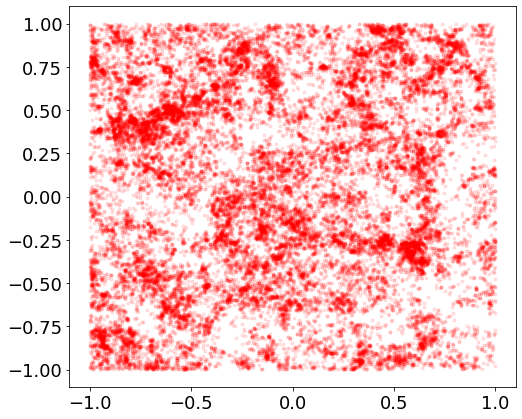

In [18]:
plt.scatter(halo_xs, halo_ys, color = 'r', marker = '.', alpha = 0.1)

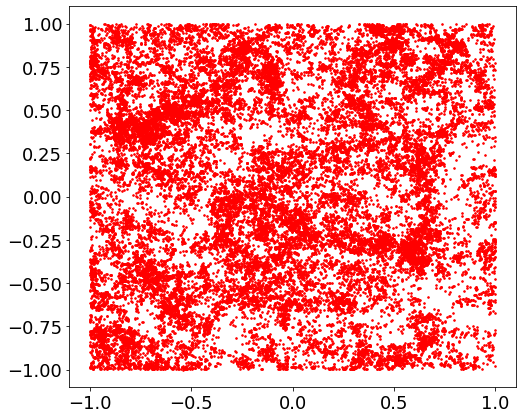

In [19]:
plt.scatter(halo_xs, halo_ys, marker = '.', c = 'r', s = 10)

Which needs to be plotted in our map space. We use:

In [20]:
def halo_centpix(halo_xpos, halo_ypos):
    
    halo_centpix_x = [0 for i in range(len(halo_xpos))]
    halo_centpix_y = [0 for i in range(len(halo_ypos))]

    for i in range(len(halo_xpos)):
        halo_centpix_x[i] = np.argmin(np.abs(halo_xpos[i] - m_noise.mapinst.pix_bincents_x))
    for i in range(len(halo_ypos)):
        halo_centpix_y[i] = np.argmin(np.abs(halo_ypos[i] - m_noise.mapinst.pix_bincents_y))
        
    return halo_centpix_x, halo_centpix_y  

In [21]:
halo_centpix_x, halo_centpix_y = halo_centpix(halo_xs, halo_ys)

We could adjust the marker size based on the halo mass. The array of those particular halo masses are:

In [22]:
halo_ms = m_noise.halos.M[thresh][good_halo_zs]
halo_ms_log = np.log10(halo_ms)
halo_ms_rad = (halo_ms)**(1/3)

In [23]:
def halo_mark_size(halo_mass, scaling):
    
    if scaling == 'log':
        
        print('Log scaling')
        
        halo_ms_log = np.log10(halo_mass)
        
        logM_min = np.min(halo_ms_log)
        logM_max = np.max(halo_ms_log)
        logMass_range = logM_max - logM_min
        
        delta = (size_max - size_min)/(logMass_range)
    
        b = size_min - delta*logM_min
        
        size = delta*(halo_ms_log) + b   
        
        return size
    
    if scaling == 'rad':
        
        print('Cube-root scaling')
        
        halo_ms_rad = (halo_mass)**(1/3)
        
        M_min = np.min(halo_ms_rad)
        M_max = np.max(halo_ms_rad)
        Mass_range = M_max - M_min
        
        delta = delta = (size_max - size_min)/(Mass_range)
        
        b = size_min - delta*M_min
        
        size = delta*(halo_ms_rad) + b
        
        return size
        
    if scaling == 'linear':
        
        print('Linear scaling')
        
        M_min = np.min(halo_ms)
        M_max = np.max(halo_ms)
        Mass_range = M_max - M_min
        
        delta = (size_max - size_min)/Mass_range
    
        b = size_min - delta*M_min
    
        size = delta*halo_mass + b
        
        return size
    
    else:
        return print('Unidentified scaling. No output')

In [24]:
size_min = 0.1
size_max = 10
sizes_lin = halo_mark_size(halo_ms, scaling = 'linear')

Linear scaling


Text(0.5, 1.0, 'Linear scaling, size: [0.1, 10]')

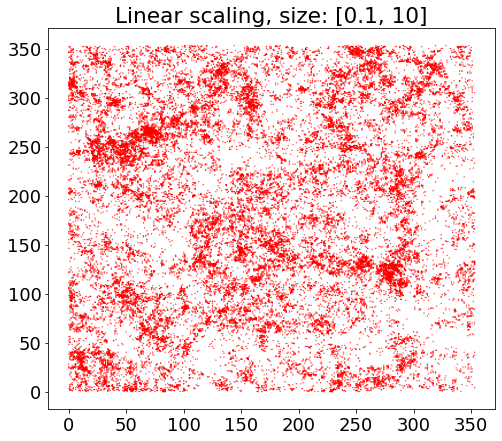

In [25]:
plt.scatter(halo_centpix_x, halo_centpix_y, color = 'r', marker = 'o', s = sizes_lin)
plt.title('Linear scaling, size: [0.1, 10]')

In [26]:
size_min = 0.1
size_max = 10
sizes_log = halo_mark_size(halo_ms, scaling = 'log')

Log scaling


Text(0.5, 1.0, 'Log scaling, size: [0.1, 10]')

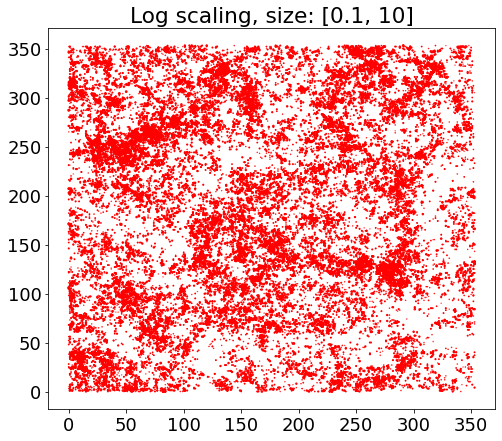

In [27]:
plt.scatter(halo_centpix_x, halo_centpix_y, color = 'r', marker = 'o', s = sizes_log)
plt.title('Log scaling, size: [0.1, 10]')

In [28]:
size_min = 0.1
size_max = 10
sizes_rad = halo_mark_size(halo_ms, scaling = 'rad')

Cube-root scaling


Text(0.5, 1.0, 'Cube-root scaling, size : [0.1, 10]')

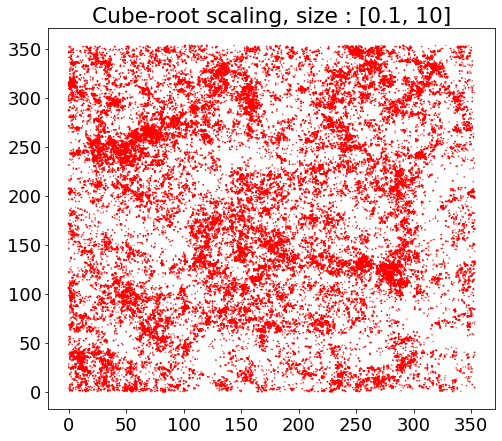

In [29]:
plt.scatter(halo_centpix_x, halo_centpix_y, color = 'r', marker = 'o', s = sizes_rad)
plt.title('Cube-root scaling, size : [0.1, 10]')

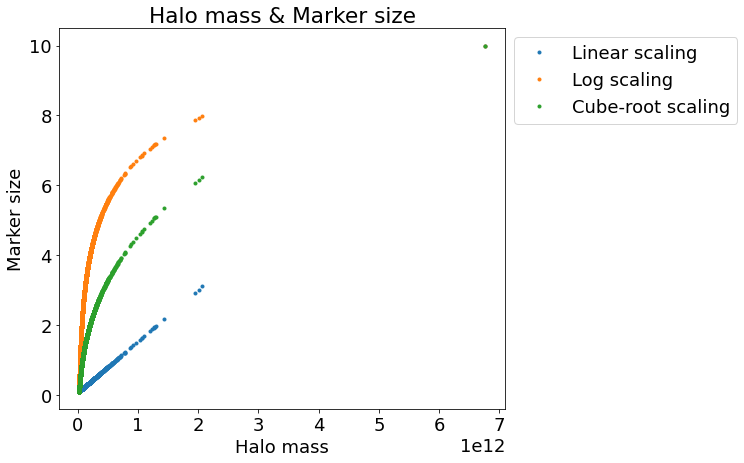

In [30]:
plt.plot(halo_ms, sizes_lin, '.', label = 'Linear scaling')
plt.plot(halo_ms, sizes_log, '.', label = 'Log scaling')
plt.plot(halo_ms, sizes_rad, '.', label = 'Cube-root scaling')
plt.title('Halo mass & Marker size')
plt.xlabel('Halo mass')
plt.ylabel('Marker size')
plt.legend(bbox_to_anchor=(1,1))

Cube-root scaling
Linear scaling
Cube-root scaling
Linear scaling
Cube-root scaling
Linear scaling


Text(0.5, 1.0, 'Linear scaling, size: [1, 50], with transparency')

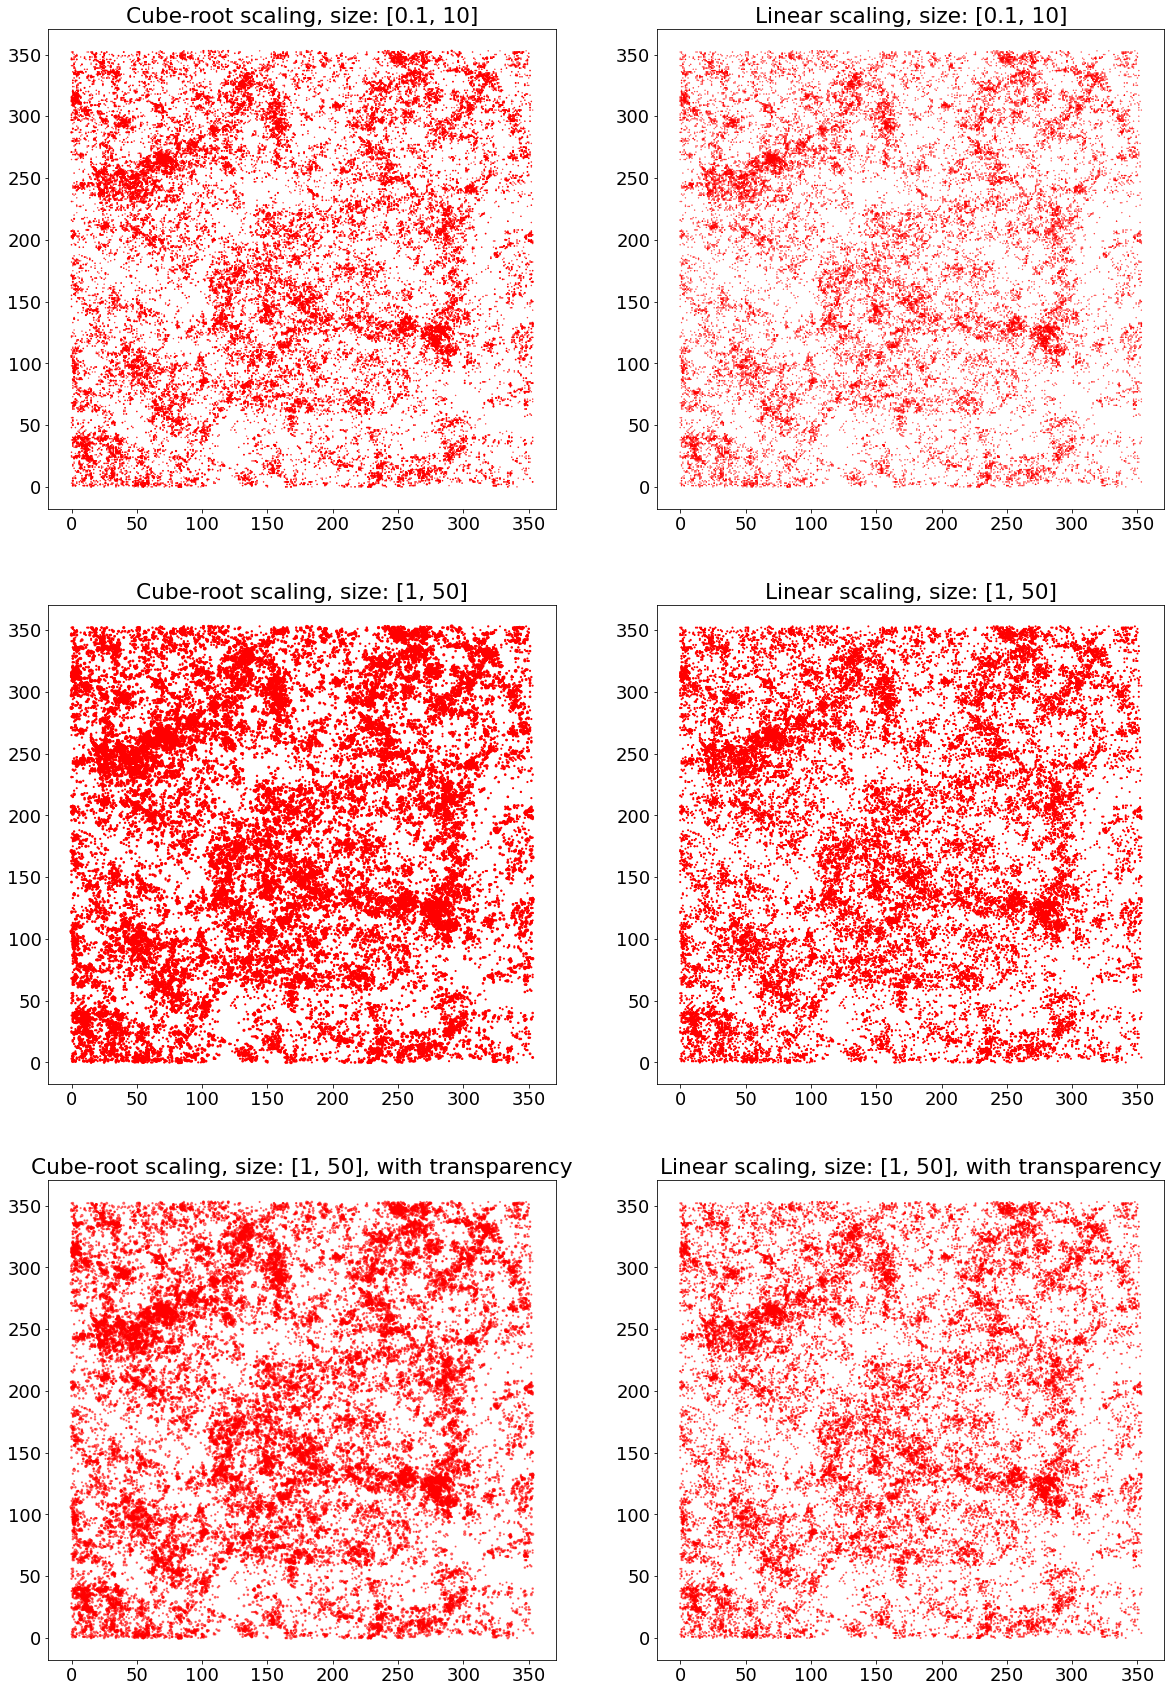

In [32]:
fig , axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 30))


size_min = 0.1
size_max = 10
sizes_rad = halo_mark_size(halo_ms, scaling = 'rad')

plt.subplot(321)
plt.scatter(halo_centpix_x, halo_centpix_y, color = 'r', marker = 'o', s = sizes_rad)
plt.title('Cube-root scaling, size: [0.1, 10]') 


size_min = 0.1
size_max = 10
sizes_lin = halo_mark_size(halo_ms, scaling = 'linear')

plt.subplot(322)
plt.scatter(halo_centpix_x, halo_centpix_y, color = 'r', marker = 'o', s = sizes_lin)
plt.title('Linear scaling, size: [0.1, 10]')


size_min = 1
size_max = 50
sizes_rad = halo_mark_size(halo_ms, scaling = 'rad')

plt.subplot(323)
plt.scatter(halo_centpix_x, halo_centpix_y, color = 'r', marker = 'o', s = sizes_rad)
plt.title('Cube-root scaling, size: [1, 50]') 


size_min = 1
size_max = 50
sizes_lin = halo_mark_size(halo_ms, scaling = 'linear')

plt.subplot(324)
plt.scatter(halo_centpix_x, halo_centpix_y, color = 'r', marker = 'o', s = sizes_lin)
plt.title('Linear scaling, size: [1, 50]')

size_min = 1
size_max = 50
sizes_rad = halo_mark_size(halo_ms, scaling = 'rad')

plt.subplot(325)
plt.scatter(halo_centpix_x, halo_centpix_y, color = 'r', marker = 'o', alpha = 0.5, s = sizes_rad)
plt.title('Cube-root scaling, size: [1, 50], with transparency') 

size_min = 1
size_max = 50
sizes_lin = halo_mark_size(halo_ms, scaling = 'linear')

plt.subplot(326)
plt.scatter(halo_centpix_x, halo_centpix_y, color = 'r', marker = 'o', alpha = 0.5, s = sizes_lin)
plt.title('Linear scaling, size: [1, 50], with transparency') 

## Juxtapose with signal

We use a cube-root marker size from 1 to 50 and we apply a bit of transparency

In [33]:
size_min = 1
size_max = 50
sizes_rad = halo_mark_size(halo_ms, scaling = 'rad')

Cube-root scaling


Text(0.5, 1.0, 'Halo positions [marker size is mass scaled]')

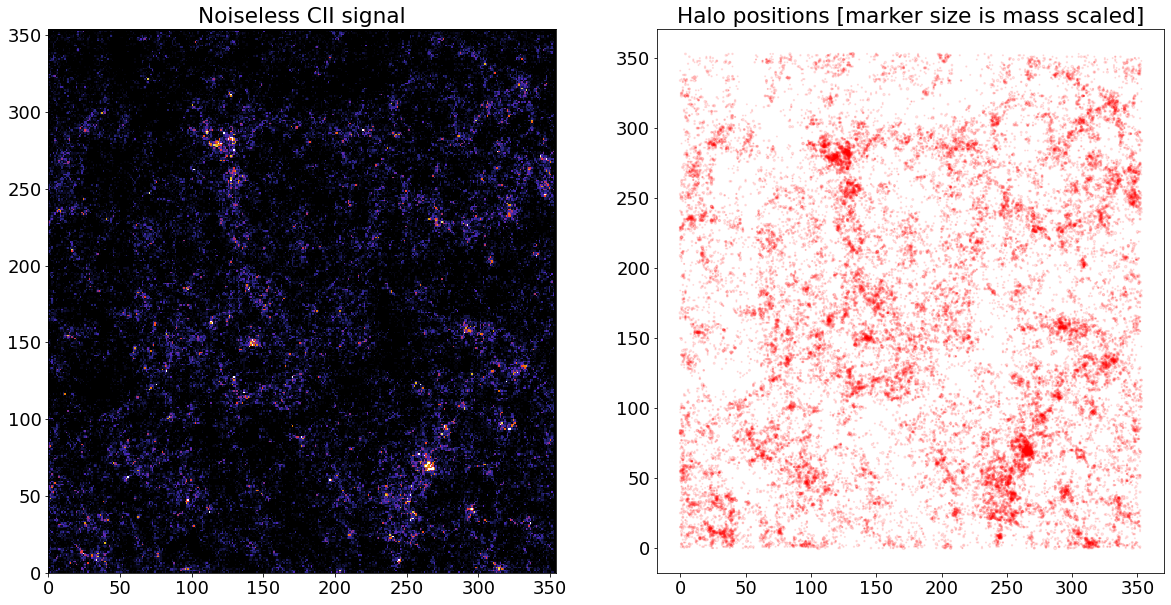

In [34]:
fig , axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))

plt.subplot(121)
plt.pcolormesh(nonoise_40[..., ind], cmap = 'CMRmap', vmax = 4000)
plt.title('Noiseless CII signal') 

plt.subplot(122)
plt.scatter(halo_centpix_y, halo_centpix_x, color = 'r', marker = 'o', alpha = 0.1, s = sizes_rad)
plt.title('Halo positions [marker size is mass scaled]') 

Text(0.5, 1.0, 'Noiseless GF CII signal')

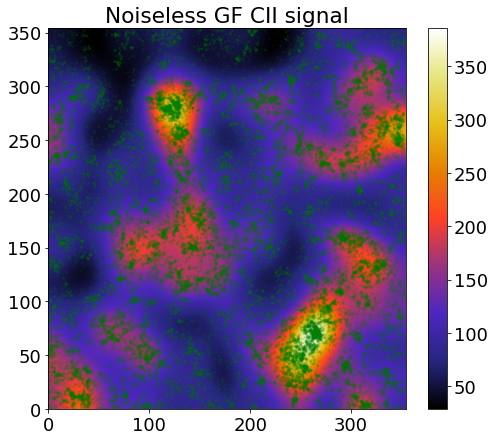

In [45]:
plt.pcolormesh(gaussian_filter((nonoise_40[..., ind]), 15), cmap = 'CMRmap')
plt.colorbar()
plt.scatter(halo_centpix_y, halo_centpix_x, color = 'g', marker = 'o', alpha = 0.1, s = sizes_rad)
plt.title('Noiseless GF CII signal') 

Text(0.5, 1.0, 'Noisy 40 000h GF CII signal')

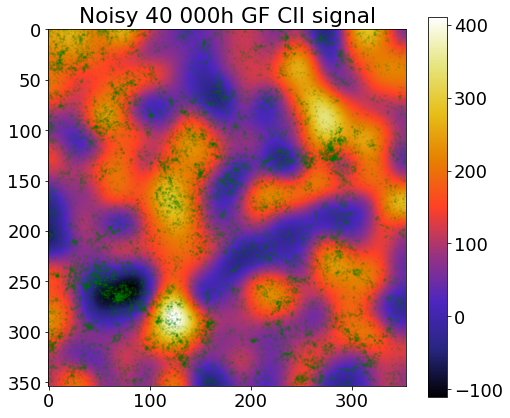

In [253]:
plt.imshow(gaussian_filter((noisy_40[..., ind]), 15), cmap = 'CMRmap')
plt.colorbar()
plt.scatter(halo_centpix_x, halo_centpix_y, color = 'g', marker = 'o', alpha = 0.08, s = sizes)
plt.title('Noisy 40 000h GF CII signal') 